# Titanic Dataset: Exploratory Data Analysis

In this notebook, we're going to analyse the famous Titanic dataset from Kaggle. The dataset is meant for supervised machine learning, but we're only going to do some exploratory analysis at this stage.

We'll try to answer the following questions:

- Who were the passengers on the Titanic? (age, gender, class.. etc)
- What deck were the passengers on and how does that relate to their class?
- Where did the passengers come from?
- Who was alone and who was with family?
- What factors helped someone survive the sinking?

In [1]:
import pandas as pd
import numpy as np
from pandas import Series,DataFrame

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
#The titanic data is available through Kaggle, after sign-up.
titanic_df = pd.read_csv('data/titanic/titan_train.csv')

In [3]:
#Looking at the first few rows in the dataset.
titanic_df.head() 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Information about the dataset. 
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


From above, we see that the dataset is missing a lot of information in for the __Cabin__ column. We'll need to deal with that when we go about using the cabin data. 

Other information seems to be complete, except some __Age__ entries.

In [5]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Pandas' awesome _describe_ method quickly gives us some aggregate stats for the dataset. 

A 1 in the Survived column means that the person survived, while a 0 mean that they died. So looking at the mean, we can say that only ~38% people survived the sinking. 

### Who were the passengers on the Titanic?

Let's look at some demographical information about the passengers.

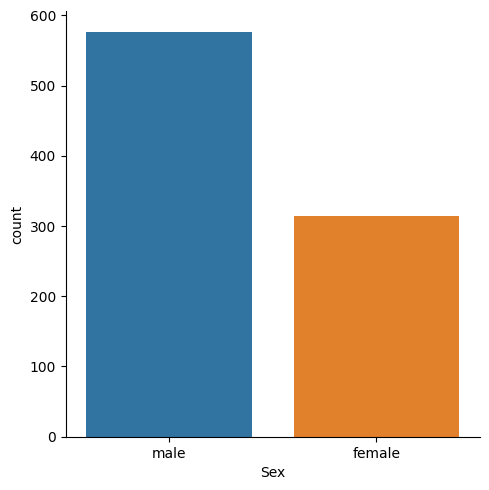

In [6]:
#Creating a factorplot, charting the number of male and female passengers
sns.catplot(x='Sex',data=titanic_df,kind='count')

Unsurprisingly, there were considerably more male passengers onboard. 

Let's take a look at how the passengers were divided among different classes. 

_Note: The __Pclass__ attribute is a proxy for the socio-economic class of a person._

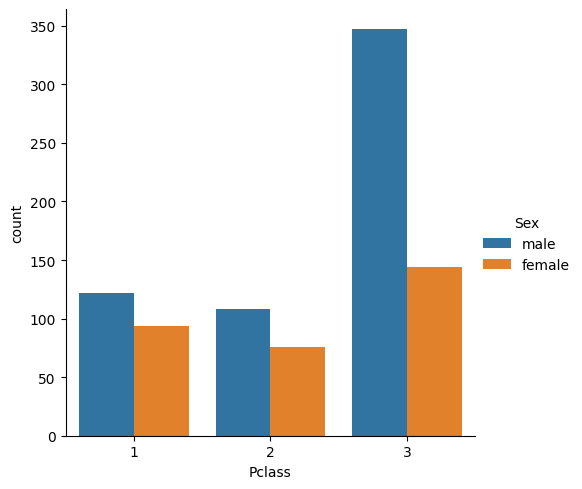

In [7]:
sns.catplot(x='Pclass',data=titanic_df,hue='Sex',kind='count')

Another thing we can do before we start infering something from the above factorplot, is to divide the passengers between male, female, and a child.

In [8]:
#Function to detect if a person is a man, woman or child.
def man_wom_chi(passenger):
    age=passenger['Age']
    sex=passenger['Sex']
    
    return 'child' if age < 16 else sex

#Using Pandas' apply method to create a new column "Person"
titanic_df['Person'] = titanic_df.apply(man_wom_chi,axis=1)

In [9]:
#Looking at the first 10 rows in the dataset, to see if our method worked.
titanic_df[0:10]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,male
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,female
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,female
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,female
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,male
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,male
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,male
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,child
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,female
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,child


In [10]:
#Getting the actual counts
print(titanic_df['Person'].value_counts())

Person
male      537
female    271
child      83
Name: count, dtype: int64


Now, let's create a factorplot to check out the distribution of men, women and children belonging to different classes.

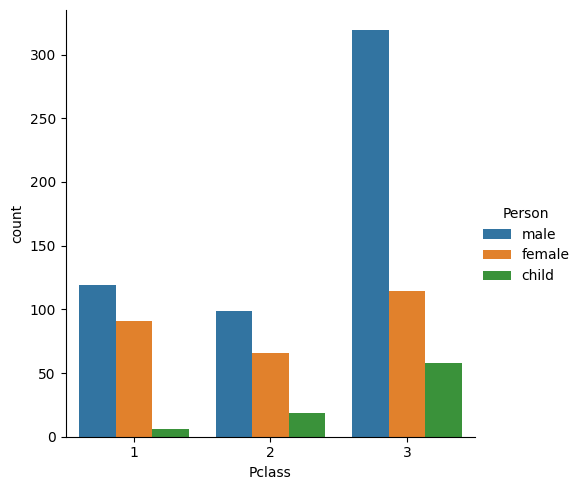

In [11]:
sns.catplot(x='Pclass',data=titanic_df,hue='Person',kind='count')

What's interesting to note above, is that there are way more male passengers than woman or childeren, in the 3rd class, than any other class. This will lead to an interesting analysis later on.

We can quickly create a histogram from the dataset, to check out the distribution of passengers of different age groups.

<Axes: >

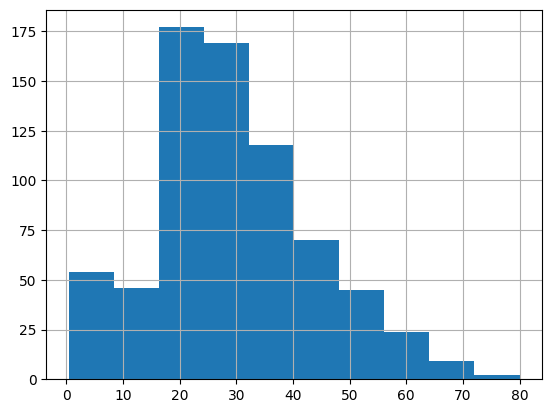

In [12]:
titanic_df['Age'].hist()

Let's check out how the age distribution varies for different classes. We'll use Seaborn's [Facetgrid](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.FacetGrid.html) for this purpose.

/home/wolfie/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/home/wolfie/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/home/wolfie/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)


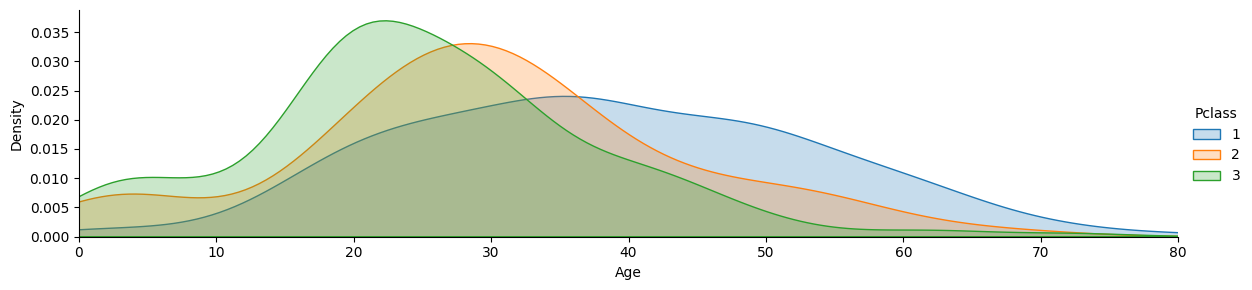

In [13]:
fig = sns.FacetGrid(titanic_df,hue='Pclass',aspect=4)

fig.map(sns.kdeplot,'Age',shade=True)

oldest = titanic_df['Age'].max()

fig.set(xlim=(0,oldest))

fig.add_legend()

Quite clearly, we can see that the first class passengers belonged more to the middle age groups, with very few children.

Second and third class had more children, with relatively fewer older people.

/home/wolfie/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/home/wolfie/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)


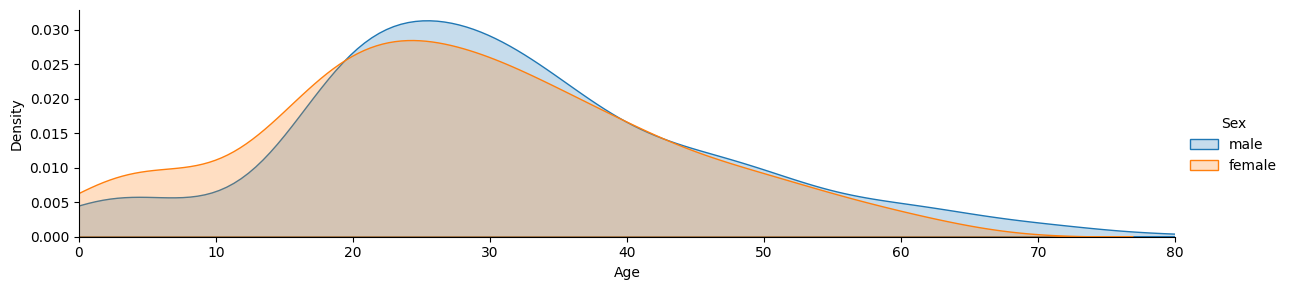

In [14]:
fig = sns.FacetGrid(titanic_df,hue='Sex',aspect=4)

fig.map(sns.kdeplot,'Age',shade=True)

oldest = titanic_df['Age'].max()

fig.set(xlim=(0,oldest))

fig.add_legend()

The age distribution seems to be less varied in terms of male and female passengers, though we can say that there more younger females than younger males.

### What deck were the passengers on and how does that relate to their class?

As we're doing open ended analysis, let's try and check out if people belonging to higher classes were assigned cabins on a higher deck (or level) of the ship.

In [15]:
#Because the cabin data was missing in a lot of cases, we can just drop it for now for this section.
deck_df = titanic_df.dropna(axis=0)

In [16]:
deck_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,female
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,female
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,male
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,child
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,female


How do we find out what deck a passenger was assigned? 

The __Cabin__ attribtute holds that data. Intuitively, the cabin number of a passenger is a combination of the deck they're on, and their room number. So a passenger on deck 'C' will have a cabin number in _CXXX_ format, where XXX can be a room number.

We just need to create a python method to extract first character from the cabin information.

In [17]:
#Grabbing the deck from the cabin numbers
def get_level(passenger):
    cabin = passenger['Cabin']
    return cabin[0]

# get_level[deck_df.iloc[1]]

In [18]:
deck_df['level']=deck_df.apply(get_level,axis=1)

/tmp/ipykernel_1163/4030337562.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deck_df['level']=deck_df.apply(get_level,axis=1)


In [19]:
deck_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person,level
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,female,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,female,C
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,male,E
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,child,G
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,female,C


Everything seems to work, so now we can check out how many passengers belonged to different decks.

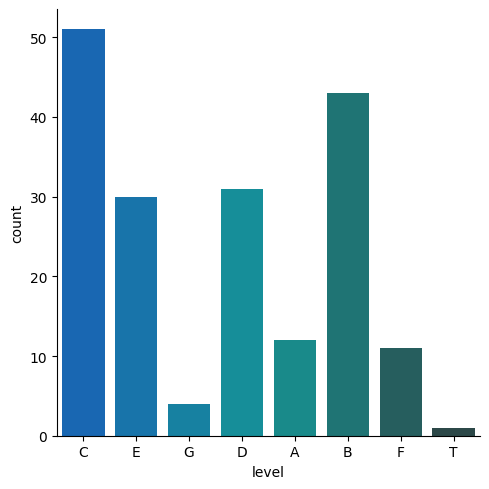

In [20]:
sns.catplot(x='level',data=deck_df,palette='winter_d',kind='count')

And to answer our original question..

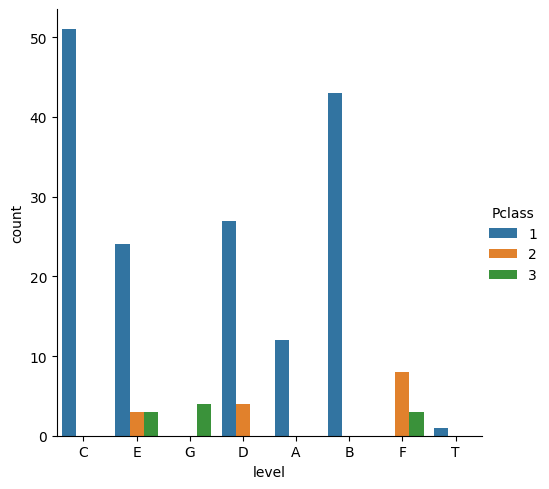

In [21]:
sns.catplot(x='level',data=deck_df,hue='Pclass',kind='count')

It feels like passengers belonging to the upper classes are indeed assigned to the upper decks. Decks A,B and C were assigned only to first class passengers, and we start seeing third class passengers only from level E. Though, we have to keep in mind that cabin information was missing for more than 3/4 of our passengers.

### Where did the passengers come from?

The __Embarked__ attribute contains data for the passengers' port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton). 

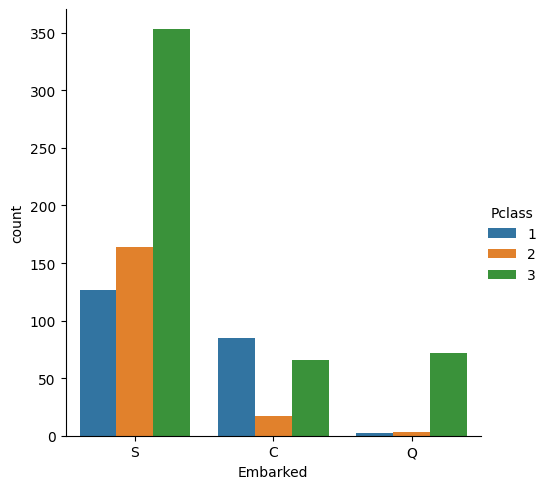

In [22]:
sns.catplot(x='Embarked',data=titanic_df,hue='Pclass',kind='count')

Most of the passengers embarked from Southampton (including Jack and Rose, in the movie). What's also interesting, is that almost no first or second class passengers embarked from Queenstown, which can tell us something about the socio-economic status of the population of Queenstown.

### Who was with their family?

Let's take another look at our data:

In [23]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,male
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,female
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,female
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,female
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,male


The __SibsSP__ attribute refers to the number of siblings or spouses that a passenger had aboard. __Parch__ refers to the number of parents or children someone had on the ship.

As we're just trying to know if a passenger had _someone_ from his family onboard, we can make our life a bit easier by making another column to represent this data.

In [24]:
#Adding the number of family a passenger had onboard
titanic_df['Alone'] = titanic_df.SibSp + titanic_df.Parch

In [25]:
titanic_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person,Alone
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S,male,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,female,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,female,3
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,male,0
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,male,0


Anything above the other than 0 in the new __Alone__ column means that the person wasn't alone. So we're going to use that column to define our 'Alone' stats more clearly.

In [26]:
titanic_df['Alone'].loc[titanic_df['Alone']>0] = 'No'

titanic_df['Alone'].loc[titanic_df['Alone']==0] = 'Yes'

/tmp/ipykernel_1163/4188309621.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_df['Alone'].loc[titanic_df['Alone']>0] = 'No'


In [27]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,male,No
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,female,No
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,female,Yes
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,female,No
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,male,Yes


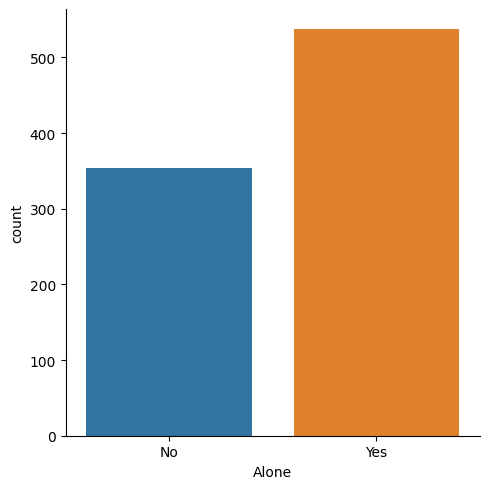

In [28]:
sns.catplot(x='Alone',data=titanic_df,kind='count')

The information is pretty simple to digest now. The majority of people on the ship had family on the ship. But did that make a difference in their chances of survival? We'll answer the question in the next section.

### What factors helped someone survive the sinking?

Looking at the 

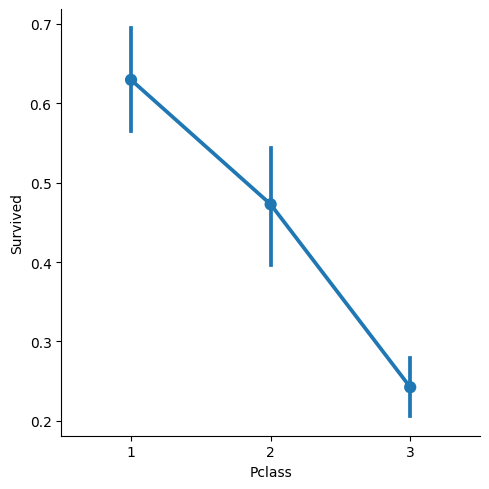

In [29]:
sns.catplot(x='Pclass',y='Survived',data=titanic_df,kind='point')

To not much surprise, it seems like lower class passengers had a lower chance of survival. 

But wait, we saw earlier that there were more men than woman or children, in the 3rd class than in any other class. From the movie 'Titanic', you might remember the 'Women and children first!' protocol that the ship's administration followed while putting passengers on the lifeboats. 

Let's see if this is really the case, by using the 'Person' column as the hue in the factorplot.

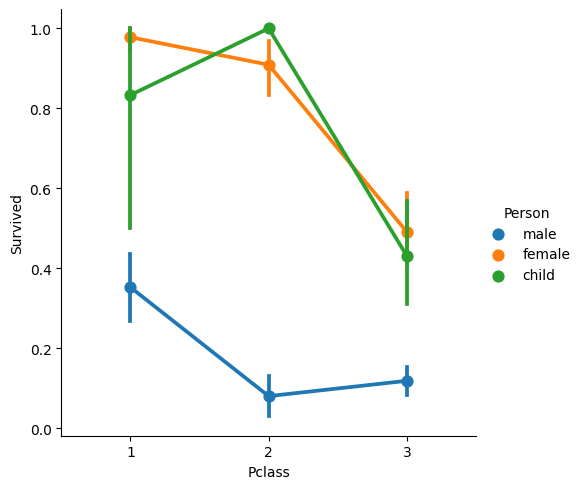

In [30]:
sns.catplot(x='Pclass',y='Survived',hue='Person',data=titanic_df, kind='point')

And this confirms our suspicion. Men had lower chances of survival than women and children, as they had lower priority of being saved. 

We can still generally say that men, women and children belonging to the 3rd class had a lesser chance at survival than their counterparts belonging to the 1st class.

Let's see if there's a relation between the age and survival.

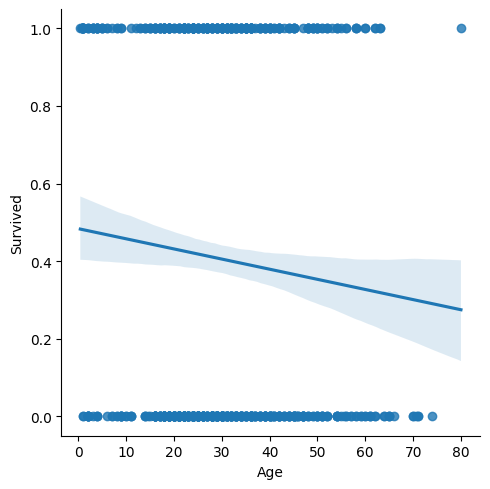

In [31]:
sns.lmplot(x='Age',y='Survived',data=titanic_df)

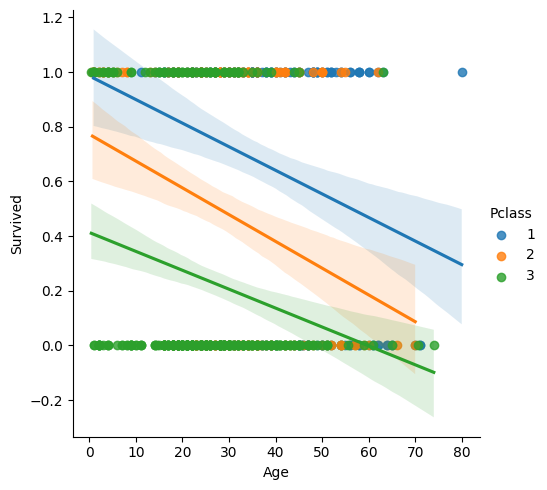

In [32]:
sns.lmplot(x='Age',y='Survived',hue='Pclass',data=titanic_df)

The general concensus from the above two figures seems to be that older people were less likely to survive. 

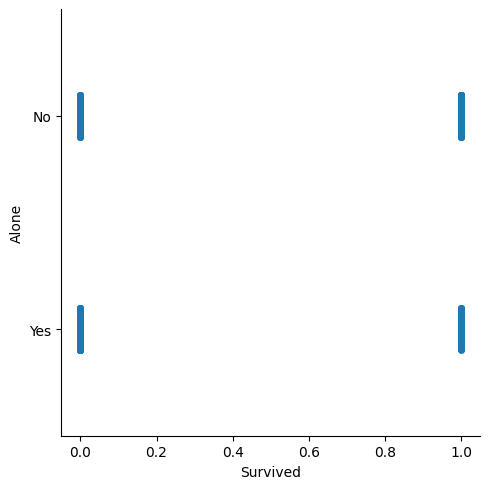

In [33]:
sns.catplot(x='Survived',y='Alone',data=titanic_df)

And if you knew someone on the ship, you had a higher chance of survival, than if you were all alone. Company's always good.

To add to this project, we can try running ML algorithms on the data (both the original dataset, and with the modifications we've made), to see if we can create a model that accurately predicts the survival of a passenger. 

This notebook will be updated with those sections in the future.